In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

/Users/kunthshah/Desktop/Crypto-Price-Moevement-Prediction/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
df = pd.read_csv('Dataset/crypto_price_movement_dataset_with_lags.csv')
df.head()

,Date,Open_Price,Close_Price,High_Price,Low_Price,Price_Change,Volume,MA_5,MA_10,RSI,...,MA_10_lag_1,MA_10_lag_2,MA_10_lag_3,MA_10_lag_4,MA_10_lag_5,MA_10_lag_6,MA_10_lag_7,MA_10_lag_8,Momentum_ratios,Sentiment_deltas
0,2023-01-12,59097.295565,59029.726208,59900.004347,58784.035582,-67.569357,4462601,49045.482581,44580.256718,33.144940,...,44528.878721,45577.477694,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.898218,0.294423
1,2023-01-13,54973.279224,55151.317602,55396.713428,54378.735255,178.038378,9775141,48852.372428,44929.860092,43.650581,...,44580.256718,44528.878721,45577.477694,0.000000,0.000000,0.000000,0.0,0.0,0.934297,-1.048490
2,2023-01-14,36370.173320,36497.900856,36938.992350,36371.219308,127.727536,5726515,46570.552431,43760.010546,44.739048,...,44929.860092,44580.256718,44528.878721,45577.477694,0.000000,0.000000,0.0,0.0,0.661777,-1.083444
3,2023-01-15,35454.749016,35059.052567,35211.603012,34107.853810,-395.696449,4617507,43367.089528,43805.992068,37.650721,...,43760.010546,44929.860092,44580.256718,44528.878721,45577.477694,0.000000,0.0,0.0,0.960577,-1.199126
4,2023-01-16,35502.135296,35750.062833,36428.171405,35625.323065,247.927537,4181273,44297.612013,43903.552042,39.993981,...,43805.992068,43760.010546,44929.860092,44580.256718,44528.878721,45577.477694,0.0,0.0,1.019710,0.543907


In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# 1. Split raw DataFrame by time (70/15/15)
n = len(df)
train_end = int(n * 0.70)
val_end   = train_end + int(n * 0.15)

train_df = df.iloc[:train_end].copy()
val_df   = df.iloc[train_end:val_end].copy()
test_df  = df.iloc[val_end:].copy()

# 2. Identify feature columns (exclude Date, target, and any leakage features)
feature_cols = [
    'Close_Price','Global_Economy','High_Price','Low_Price',
    'MA_10','MA_10_lag_2','Open_Price','RSI','Volatility'
    # add any engineered features here
]

# 3. Fit scaler on TRAIN only, then transform all splits
scaler = StandardScaler()
train_df[feature_cols] = scaler.fit_transform(train_df[feature_cols])
val_df[feature_cols]   = scaler.transform(val_df[feature_cols])
test_df[feature_cols]  = scaler.transform(test_df[feature_cols])

# 4. Function to build time‑windows
def create_time_windows(df, feature_cols, window_size=10):
    X, y = [], []
    for i in range(window_size, len(df)):
        X.append(df[feature_cols].iloc[i-window_size:i].values)
        y.append(df['Price_Movement'].iloc[i])
    return np.array(X), np.array(y)

# 5. Create windowed datasets
window_size = 10
X_train, y_train = create_time_windows(train_df, feature_cols, window_size)
X_val,   y_val   = create_time_windows(val_df,   feature_cols, window_size)
X_test,  y_test  = create_time_windows(test_df,  feature_cols, window_size)

print("Shapes:",
      X_train.shape, y_train.shape,
      X_val.shape,   y_val.shape,
      X_test.shape,  y_test.shape)


Shapes: (34982, 10, 9) (34982,) (7488, 10, 9) (7488,) (7489, 10, 9) (7489,)


In [14]:
model_simple = Sequential()
model_simple.add(LSTM(50, activation='relu', input_shape=(window_size, len(feature_cols))))
model_simple.add(Dense(1, activation='sigmoid'))
model_simple.add(Dense(1, activation='softmax'))


model_simple.compile(optimizer=Adam(1e-3), loss='binary_crossentropy', metrics=['AUC', 'accuracy'])
print(model_simple.summary())

history_simple = model_simple.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=64,
    verbose=1
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                  │ (None, 50)             │        12,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            51 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,053 (47.08 KB)

 Trainable params: 12,053 (47.08 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.5000 - accuracy: 0.5009 - loss: 0.6959 - val_AUC: 0.5000 - val_accuracy: 0.4983 - val_loss: 0.6933
Epoch 2/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.5000 - accuracy: 0.5067 - loss: 0.6931 - val_AUC: 0.5000 - val_accuracy: 0.4983 - val_loss: 0.6932
Epoch 3/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.5000 - accuracy: 0.5024 - loss: 0.6931 - val_AUC: 0.5000 - val_accuracy: 0.4983 - val_loss: 0.6932
Epoch 4/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.5000 - accuracy: 0.5010 - loss: 0.6931 - val_AUC: 0.5000 - val_accuracy: 0.4983 - val_loss: 0.6932
Epoch 5/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.5000 - accuracy: 0.5017 - loss: 0.6932 - val_AUC: 0.5000 - val_accuracy: 0.4983 - val_loss: 0.6932
Epoch 6/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.5000 - accuracy: 0.5035 - loss: 0.6931 - val_AUC: 0.5000 - val_accuracy: 0.4983 - val_loss: 0.6932
Epoch 7/20
547/547 ━━━━━━━━━━━━━━━━

# Attention on top of LSTM

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, LSTM, Dense, Dropout, BatchNormalization, 
    Permute, Multiply, Lambda, Softmax, Concatenate
)

def attention_block(inputs):
    # inputs.shape = (batch, timesteps, features)
    # 1) Learn a score for each timestep
    a = Permute((2,1))(inputs)                       # (batch, features, timesteps)
    a = Dense(inputs.shape[1], activation='tanh')(a) # (batch, features, timesteps)
    a = Softmax(axis=-1)(a)                          # normalize over timesteps
    a_probs = Permute((2,1))(a)                      # (batch, timesteps, features)
    # 2) Weight the inputs
    output = Multiply()([inputs, a_probs])           # (batch, timesteps, features)
    # 3) Sum across time
    return Lambda(lambda x: tf.reduce_sum(x, axis=1))(output)

def create_lstm_with_attention(timesteps, n_features):
    inp = Input(shape=(timesteps, n_features))
    
    x = LSTM(64, return_sequences=True)(inp)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    
    x = LSTM(32, return_sequences=True)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    
    # Attention pooling
    x = attention_block(x)   # (batch, features)
    
    x = Dense(16, activation='relu')(x)
    x = Dropout(0.2)(x)
    out = Dense(1, activation='sigmoid')(x)
    
    model = Model(inp, out)
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['AUC','accuracy']
    )
    return model

model_attn = create_lstm_with_attention(X_train.shape[1], X_train.shape[2])
model_attn.summary()


Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 10, 9)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_6 (LSTM)       │ (None, 10, 64)    │     18,944 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10, 64)    │        256 │ lstm_6[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 10, 64)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_7 (LSTM)       │ (None, 10, 32)    │     12,416 │ dropout_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10, 32)    │        128 │ lstm_7[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 10, 32)    │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute (Permute)   │ (None, 32, 10)    │          0 │ dropout_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 32, 10)    │        110 │ permute[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softmax (Softmax)   │ (None, 32, 10)    │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute_1 (Permute) │ (None, 10, 32)    │          0 │ softmax[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 10, 32)    │          0 │ dropout_10[0][0], │
│                     │                   │            │ permute_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 32)        │          0 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 16)        │        528 │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 16)        │          0 │ dense_7[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 1)         │         17 │ dropout_11[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 32,399 (126.56 KB)

 Trainable params: 32,207 (125.81 KB)

 Non-trainable params: 192 (768.00 B)

In [10]:
# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6),
    ModelCheckpoint('best_lstm_model.h5', monitor='val_loss', save_best_only=True)
]

# Train
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    callbacks=callbacks,
    verbose=2
)

Epoch 1/100


547/547 - 5s - 8ms/step - AUC: 0.5009 - accuracy: 0.5023 - loss: 0.6932 - val_AUC: 0.4917 - val_accuracy: 0.4959 - val_loss: 0.6934 - learning_rate: 1.0000e-03
Epoch 2/100


547/547 - 4s - 7ms/step - AUC: 0.5046 - accuracy: 0.5046 - loss: 0.6931 - val_AUC: 0.5033 - val_accuracy: 0.4977 - val_loss: 0.6932 - learning_rate: 1.0000e-03
Epoch 3/100
547/547 - 3s - 6ms/step - AUC: 0.5002 - accuracy: 0.5015 - loss: 0.6932 - val_AUC: 0.5069 - val_accuracy: 0.4981 - val_loss: 0.6932 - learning_rate: 1.0000e-03
Epoch 4/100
547/547 - 4s - 7ms/step - AUC: 0.4945 - accuracy: 0.5028 - loss: 0.6932 - val_AUC: 0.5003 - val_accuracy: 0.4988 - val_loss: 0.6932 - learning_rate: 1.0000e-03
Epoch 5/100


547/547 - 4s - 7ms/step - AUC: 0.5003 - accuracy: 0.5034 - loss: 0.6931 - val_AUC: 0.5015 - val_accuracy: 0.4979 - val_loss: 0.6932 - learning_rate: 1.0000e-03
Epoch 6/100


547/547 - 3s - 6ms/step - AUC: 0.5026 - accuracy: 0.5030 - loss: 0.6931 - val_AUC: 0.5020 - val_accuracy: 0.4983 - val_loss: 0.6932 - learning_rate: 1.0000e-03
Epoch 7/100


547/547 - 3s - 6ms/step - AUC: 0.4977 - accuracy: 0.5044 - loss: 0.6932 - val_AUC: 0.4982 - val_accuracy: 0.4931 - val_loss: 0.6932 - learning_rate: 1.0000e-03
Epoch 8/100
547/547 - 3s - 6ms/step - AUC: 0.5035 - accuracy: 0.5045 - loss: 0.6931 - val_AUC: 0.4885 - val_accuracy: 0.4949 - val_loss: 0.6933 - learning_rate: 5.0000e-04
Epoch 9/100
547/547 - 3s - 6ms/step - AUC: 0.4995 - accuracy: 0.5011 - loss: 0.6931 - val_AUC: 0.5047 - val_accuracy: 0.4983 - val_loss: 0.6932 - learning_rate: 5.0000e-04
Epoch 10/100
547/547 - 3s - 6ms/step - AUC: 0.5009 - accuracy: 0.5042 - loss: 0.6931 - val_AUC: 0.5005 - val_accuracy: 0.4983 - val_loss: 0.6932 - learning_rate: 5.0000e-04
Epoch 11/100
547/547 - 3s - 6ms/step - AUC: 0.4950 - accuracy: 0.5032 - loss: 0.6931 - val_AUC: 0.4999 - val_accuracy: 0.4983 - val_loss: 0.6932 - learning_rate: 5.0000e-04
Epoch 12/100
547/547 - 3s - 6ms/step - AUC: 0.5021 - accuracy: 0.5048 - loss: 0.6931 - val_AUC: 0.5009 - val_accuracy: 0.4983 - val_loss: 0.6932 - lea

547/547 - 3s - 6ms/step - AUC: 0.5023 - accuracy: 0.5040 - loss: 0.6931 - val_AUC: 0.5028 - val_accuracy: 0.4983 - val_loss: 0.6932 - learning_rate: 2.5000e-04
Epoch 14/100


547/547 - 3s - 6ms/step - AUC: 0.5055 - accuracy: 0.5038 - loss: 0.6930 - val_AUC: 0.5061 - val_accuracy: 0.4981 - val_loss: 0.6931 - learning_rate: 2.5000e-04
Epoch 15/100
547/547 - 3s - 6ms/step - AUC: 0.5052 - accuracy: 0.5037 - loss: 0.6929 - val_AUC: 0.5006 - val_accuracy: 0.4983 - val_loss: 0.6934 - learning_rate: 2.5000e-04
Epoch 16/100
547/547 - 3s - 6ms/step - AUC: 0.5019 - accuracy: 0.5045 - loss: 0.6930 - val_AUC: 0.5003 - val_accuracy: 0.4983 - val_loss: 0.6933 - learning_rate: 2.5000e-04
Epoch 17/100


547/547 - 3s - 6ms/step - AUC: 0.5037 - accuracy: 0.5031 - loss: 0.6930 - val_AUC: 0.5050 - val_accuracy: 0.4983 - val_loss: 0.6931 - learning_rate: 2.5000e-04
Epoch 18/100


547/547 - 3s - 6ms/step - AUC: 0.5066 - accuracy: 0.5044 - loss: 0.6929 - val_AUC: 0.5058 - val_accuracy: 0.4985 - val_loss: 0.6929 - learning_rate: 2.5000e-04
Epoch 19/100
547/547 - 3s - 6ms/step - AUC: 0.5077 - accuracy: 0.5045 - loss: 0.6927 - val_AUC: 0.5036 - val_accuracy: 0.5007 - val_loss: 0.6929 - learning_rate: 2.5000e-04
Epoch 20/100


547/547 - 3s - 6ms/step - AUC: 0.5083 - accuracy: 0.5065 - loss: 0.6929 - val_AUC: 0.5068 - val_accuracy: 0.5019 - val_loss: 0.6929 - learning_rate: 2.5000e-04
Epoch 21/100
547/547 - 3s - 6ms/step - AUC: 0.5079 - accuracy: 0.5047 - loss: 0.6928 - val_AUC: 0.4990 - val_accuracy: 0.4993 - val_loss: 0.6932 - learning_rate: 2.5000e-04
Epoch 22/100
547/547 - 3s - 6ms/step - AUC: 0.5089 - accuracy: 0.5084 - loss: 0.6929 - val_AUC: 0.5026 - val_accuracy: 0.5033 - val_loss: 0.6931 - learning_rate: 2.5000e-04
Epoch 23/100
547/547 - 3s - 6ms/step - AUC: 0.5111 - accuracy: 0.5066 - loss: 0.6928 - val_AUC: 0.5098 - val_accuracy: 0.5000 - val_loss: 0.6929 - learning_rate: 2.5000e-04
Epoch 24/100
547/547 - 3s - 6ms/step - AUC: 0.5128 - accuracy: 0.5065 - loss: 0.6926 - val_AUC: 0.5063 - val_accuracy: 0.4984 - val_loss: 0.6929 - learning_rate: 1.2500e-04
Epoch 25/100
547/547 - 3s - 6ms/step - AUC: 0.5080 - accuracy: 0.5045 - loss: 0.6927 - val_AUC: 0.5050 - val_accuracy: 0.4979 - val_loss: 0.6929 - l

547/547 - 3s - 6ms/step - AUC: 0.5122 - accuracy: 0.5071 - loss: 0.6926 - val_AUC: 0.5088 - val_accuracy: 0.5012 - val_loss: 0.6929 - learning_rate: 1.2500e-04
Epoch 27/100
547/547 - 3s - 6ms/step - AUC: 0.5107 - accuracy: 0.5077 - loss: 0.6926 - val_AUC: 0.5074 - val_accuracy: 0.4964 - val_loss: 0.6930 - learning_rate: 1.2500e-04
Epoch 28/100
547/547 - 3s - 6ms/step - AUC: 0.5131 - accuracy: 0.5067 - loss: 0.6923 - val_AUC: 0.5098 - val_accuracy: 0.5028 - val_loss: 0.6929 - learning_rate: 1.2500e-04
Epoch 29/100
547/547 - 3s - 6ms/step - AUC: 0.5155 - accuracy: 0.5089 - loss: 0.6925 - val_AUC: 0.5065 - val_accuracy: 0.5000 - val_loss: 0.6929 - learning_rate: 6.2500e-05
Epoch 30/100
547/547 - 3s - 6ms/step - AUC: 0.5107 - accuracy: 0.5097 - loss: 0.6925 - val_AUC: 0.5072 - val_accuracy: 0.4971 - val_loss: 0.6931 - learning_rate: 6.2500e-05
Epoch 31/100
547/547 - 3s - 6ms/step - AUC: 0.5138 - accuracy: 0.5076 - loss: 0.6924 - val_AUC: 0.5059 - val_accuracy: 0.4977 - val_loss: 0.6929 - l

# CNN with LSTM

In [12]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D

def create_cnn_lstm(timesteps, n_features):
    inp = Input(shape=(timesteps, n_features))
    
    # Convolutional front‑end
    x = Conv1D(64, kernel_size=3, activation='relu', padding='same')(inp)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.2)(x)
    
    x = Conv1D(32, kernel_size=3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.2)(x)
    
    # LSTM back‑end
    x = LSTM(32)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    
    x = Dense(16, activation='relu')(x)
    x = Dropout(0.2)(x)
    out = Dense(1, activation='sigmoid')(x)
    
    model = Model(inp, out)
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['AUC','accuracy']
    )
    return model

model_cnn_lstm = create_cnn_lstm(X_train.shape[1], X_train.shape[2])
model_cnn_lstm.summary()

Model: "functional_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 10, 9)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 64)         │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 10, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 5, 32)          │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 5, 32)          │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 2, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 2, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,345 (67.75 KB)

 Trainable params: 17,089 (66.75 KB)

 Non-trainable params: 256 (1.00 KB)

In [13]:
# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6),
    ModelCheckpoint('best_lstm_model.h5', monitor='val_loss', save_best_only=True)
]

# Train
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    callbacks=callbacks,
    verbose=2
)

Epoch 1/100


547/547 - 4s - 6ms/step - AUC: 0.5104 - accuracy: 0.5056 - loss: 0.6925 - val_AUC: 0.5072 - val_accuracy: 0.5011 - val_loss: 0.6929 - learning_rate: 3.1250e-05
Epoch 2/100
547/547 - 3s - 6ms/step - AUC: 0.5106 - accuracy: 0.5051 - loss: 0.6926 - val_AUC: 0.5096 - val_accuracy: 0.5001 - val_loss: 0.6930 - learning_rate: 3.1250e-05
Epoch 3/100


547/547 - 4s - 7ms/step - AUC: 0.5139 - accuracy: 0.5102 - loss: 0.6926 - val_AUC: 0.5098 - val_accuracy: 0.4975 - val_loss: 0.6929 - learning_rate: 3.1250e-05
Epoch 4/100


547/547 - 3s - 6ms/step - AUC: 0.5148 - accuracy: 0.5083 - loss: 0.6924 - val_AUC: 0.5107 - val_accuracy: 0.4977 - val_loss: 0.6929 - learning_rate: 3.1250e-05
Epoch 5/100
547/547 - 4s - 7ms/step - AUC: 0.5104 - accuracy: 0.5067 - loss: 0.6927 - val_AUC: 0.5123 - val_accuracy: 0.4980 - val_loss: 0.6929 - learning_rate: 3.1250e-05
Epoch 6/100


547/547 - 3s - 6ms/step - AUC: 0.5114 - accuracy: 0.5060 - loss: 0.6925 - val_AUC: 0.5097 - val_accuracy: 0.5000 - val_loss: 0.6929 - learning_rate: 3.1250e-05
Epoch 7/100
547/547 - 3s - 6ms/step - AUC: 0.5115 - accuracy: 0.5043 - loss: 0.6924 - val_AUC: 0.5090 - val_accuracy: 0.4983 - val_loss: 0.6929 - learning_rate: 1.5625e-05
Epoch 8/100
547/547 - 3s - 6ms/step - AUC: 0.5135 - accuracy: 0.5069 - loss: 0.6925 - val_AUC: 0.5087 - val_accuracy: 0.4989 - val_loss: 0.6929 - learning_rate: 1.5625e-05
Epoch 9/100


547/547 - 3s - 6ms/step - AUC: 0.5149 - accuracy: 0.5087 - loss: 0.6924 - val_AUC: 0.5078 - val_accuracy: 0.4996 - val_loss: 0.6929 - learning_rate: 1.5625e-05
Epoch 10/100
547/547 - 3s - 6ms/step - AUC: 0.5112 - accuracy: 0.5075 - loss: 0.6925 - val_AUC: 0.5082 - val_accuracy: 0.4996 - val_loss: 0.6929 - learning_rate: 1.5625e-05
Epoch 11/100
547/547 - 3s - 6ms/step - AUC: 0.5135 - accuracy: 0.5088 - loss: 0.6924 - val_AUC: 0.5082 - val_accuracy: 0.4987 - val_loss: 0.6929 - learning_rate: 1.5625e-05
Epoch 12/100
547/547 - 3s - 6ms/step - AUC: 0.5136 - accuracy: 0.5087 - loss: 0.6925 - val_AUC: 0.5098 - val_accuracy: 0.4987 - val_loss: 0.6929 - learning_rate: 7.8125e-06
Epoch 13/100
547/547 - 3s - 6ms/step - AUC: 0.5151 - accuracy: 0.5098 - loss: 0.6924 - val_AUC: 0.5087 - val_accuracy: 0.4983 - val_loss: 0.6929 - learning_rate: 7.8125e-06
Epoch 14/100
547/547 - 3s - 6ms/step - AUC: 0.5130 - accuracy: 0.5083 - loss: 0.6923 - val_AUC: 0.5089 - val_accuracy: 0.4993 - val_loss: 0.6929 - l

# TCN

In [17]:
# Install keras-tcn if needed: pip install keras-tcn
from tcn import TCN

def create_tcn(timesteps, n_features):
    inp = Input(shape=(timesteps, n_features))
    x = TCN(nb_filters=64, kernel_size=3, dilations=[1,2,4,8],
            return_sequences=False, activation='relu')(inp)
    x = Dropout(0.2)(x)
    
    x = Dense(16, activation='relu')(x)
    x = Dropout(0.2)(x)
    out = Dense(1, activation='sigmoid')(x)
    
    model = Model(inp, out)
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['AUC','accuracy']
    )
    return model

model_tcn = create_tcn(X_train.shape[1], X_train.shape[2])
model_tcn.summary()


Model: "functional_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 10, 9)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tcn (TCN)                       │ (None, 64)             │        88,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 89,953 (351.38 KB)

 Trainable params: 89,953 (351.38 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6),
    ModelCheckpoint('best_lstm_model.h5', monitor='val_loss', save_best_only=True)
]

# Train
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    callbacks=callbacks,
    verbose=2
)

Epoch 1/100


547/547 - 4s - 6ms/step - AUC: 0.5129 - accuracy: 0.5103 - loss: 0.6922 - val_AUC: 0.5074 - val_accuracy: 0.4996 - val_loss: 0.6929 - learning_rate: 3.9063e-06
Epoch 2/100


547/547 - 3s - 6ms/step - AUC: 0.5166 - accuracy: 0.5111 - loss: 0.6923 - val_AUC: 0.5082 - val_accuracy: 0.4980 - val_loss: 0.6929 - learning_rate: 3.9063e-06
Epoch 3/100
547/547 - 3s - 6ms/step - AUC: 0.5144 - accuracy: 0.5081 - loss: 0.6924 - val_AUC: 0.5087 - val_accuracy: 0.4985 - val_loss: 0.6929 - learning_rate: 3.9063e-06
Epoch 4/100


547/547 - 3s - 6ms/step - AUC: 0.5107 - accuracy: 0.5096 - loss: 0.6923 - val_AUC: 0.5082 - val_accuracy: 0.4983 - val_loss: 0.6929 - learning_rate: 3.9063e-06
Epoch 5/100
547/547 - 3s - 6ms/step - AUC: 0.5147 - accuracy: 0.5085 - loss: 0.6925 - val_AUC: 0.5075 - val_accuracy: 0.4989 - val_loss: 0.6929 - learning_rate: 3.9063e-06
Epoch 6/100
547/547 - 3s - 6ms/step - AUC: 0.5161 - accuracy: 0.5080 - loss: 0.6923 - val_AUC: 0.5082 - val_accuracy: 0.4988 - val_loss: 0.6929 - learning_rate: 3.9063e-06
Epoch 7/100
547/547 - 3s - 6ms/step - AUC: 0.5171 - accuracy: 0.5131 - loss: 0.6923 - val_AUC: 0.5091 - val_accuracy: 0.4991 - val_loss: 0.6929 - learning_rate: 1.9531e-06
Epoch 8/100
547/547 - 3s - 6ms/step - AUC: 0.5145 - accuracy: 0.5069 - loss: 0.6924 - val_AUC: 0.5082 - val_accuracy: 0.4989 - val_loss: 0.6929 - learning_rate: 1.9531e-06
Epoch 9/100
547/547 - 3s - 6ms/step - AUC: 0.5153 - accuracy: 0.5111 - loss: 0.6923 - val_AUC: 0.5083 - val_accuracy: 0.4987 - val_loss: 0.6929 - learni

In [20]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Conv1D, SpatialDropout1D, LayerNormalization,
    Bidirectional, LSTM, Dense, Dropout, BatchNormalization,
    Permute, Multiply, Softmax, Lambda, Concatenate
)
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

# --- 1) Attention Block ---
def attention_block(inputs):
    # inputs.shape = (batch, timesteps, features)
    # 1) Score each timestep
    a = Permute((2,1))(inputs)                          # (batch, features, timesteps)
    a = Dense(inputs.shape[1], activation='tanh')(a)    # learnable scoring
    a = Softmax(axis=-1)(a)                             # normalize over timesteps
    a = Permute((2,1))(a)                               # back to (batch, timesteps, features)
    # 2) Weight inputs and sum
    weighted = Multiply()([inputs, a])
    return Lambda(lambda x: tf.reduce_sum(x, axis=1))(weighted)

# --- 2) Build the Hybrid CNN→Bi‑LSTM→Attention Model ---
def build_robust_ts_model(window_size, n_features):
    seq_in = Input(shape=(window_size, n_features), name='seq_input')
    
    # 2A) Spatial Dropout for regularizing across features
    x = SpatialDropout1D(0.2)(seq_in)
    
    # 2B) Parallel CNN “motif” towers
    t1 = Conv1D(64, 3, padding='same', activation='relu')(x)
    t2 = Conv1D(64, 5, padding='same', activation='relu')(x)
    t3 = Conv1D(64, 7, padding='same', activation='relu')(x)
    x = Concatenate()([t1, t2, t3])
    x = LayerNormalization()(x)
    x = Dropout(0.2)(x)
    
    # 2C) Stacked Bidirectional LSTMs with LayerNorm + Dropout
    x = Bidirectional(LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))(x)
    x = LayerNormalization()(x)
    x = Bidirectional(LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))(x)
    x = LayerNormalization()(x)
    
    # 2D) Attention pooling over time
    x = attention_block(x)   # → shape (batch, features)
    
    # 2E) Deep Dense Head with regularization
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    # 2F) Final binary output
    out = Dense(1, activation='sigmoid', name='price_up')(x)
    
    model = Model(seq_in, out, name='CNN_LSTM_Attn_TS')
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=1e-3),
        metrics=['AUC','accuracy']
    )
    return model

# --- 3) Instantiate & Train ---
# assuming you have your windowed data X_train, y_train, X_val, y_val:
window_size, n_features = X_train.shape[1], X_train.shape[2]
model = build_robust_ts_model(window_size, n_features)
model.summary()

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6),
    tf.keras.callbacks.ModelCheckpoint('best_ts_model.h5', monitor='val_loss', save_best_only=True)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    callbacks=callbacks,
)


Model: "CNN_LSTM_Attn_TS"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ seq_input           │ (None, 10, 9)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_1 │ (None, 10, 9)     │          0 │ seq_input[0][0]   │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 10, 64)    │      1,792 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 10, 64)    │      2,944 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 10, 64)    │      4,096 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 10, 192)   │          0 │ conv1d_7[0][0],   │
│ (Concatenate)       │                   │            │ conv1d_8[0][0],   │
│                     │                   │            │ conv1d_9[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 192)   │        384 │ concatenate_1[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_25          │ (None, 10, 192)   │          0 │ layer_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 10, 256)   │    328,704 │ dropout_25[0][0]  │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 256)   │        512 │ bidirectional_2[… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 10, 128)   │    164,352 │ layer_normalizat… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 128)   │        256 │ bidirectional_3[… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute_4 (Permute) │ (None, 128, 10)   │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 128, 10)   │        110 │ permute_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softmax_2 (Softmax) │ (None, 128, 10)   │          0 │ dense_18[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute_5 (Permute) │ (None, 10, 128)   │          0 │ softmax_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_2          │ (None, 10, 128)   │          0 │ layer_normalizat… │
│ (Multiply)          │                   │            │ permute_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 128)       │          0 │ multiply_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 128)       │     16,512 │ lambda_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 528,751 (2.02 MB)

 Trainable params: 528,367 (2.02 MB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - AUC: 0.4954 - accuracy: 0.4985 - loss: 1.0179

547/547 ━━━━━━━━━━━━━━━━━━━━ 49s 79ms/step - AUC: 0.4954 - accuracy: 0.4985 - loss: 1.0178 - val_AUC: 0.5020 - val_accuracy: 0.5016 - val_loss: 0.8565 - learning_rate: 0.0010
Epoch 2/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - AUC: 0.5040 - accuracy: 0.5031 - loss: 0.8496

547/547 ━━━━━━━━━━━━━━━━━━━━ 46s 85ms/step - AUC: 0.5040 - accuracy: 0.5031 - loss: 0.8496 - val_AUC: 0.4964 - val_accuracy: 0.4963 - val_loss: 0.7925 - learning_rate: 0.0010
Epoch 3/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - AUC: 0.5005 - accuracy: 0.4991 - loss: 0.7825

547/547 ━━━━━━━━━━━━━━━━━━━━ 47s 85ms/step - AUC: 0.5005 - accuracy: 0.4991 - loss: 0.7825 - val_AUC: 0.4921 - val_accuracy: 0.4944 - val_loss: 0.7465 - learning_rate: 0.0010
Epoch 4/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - AUC: 0.5011 - accuracy: 0.5022 - loss: 0.7396

547/547 ━━━━━━━━━━━━━━━━━━━━ 47s 85ms/step - AUC: 0.5011 - accuracy: 0.5022 - loss: 0.7396 - val_AUC: 0.5029 - val_accuracy: 0.5048 - val_loss: 0.7182 - learning_rate: 0.0010
Epoch 5/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - AUC: 0.5105 - accuracy: 0.5104 - loss: 0.7144

547/547 ━━━━━━━━━━━━━━━━━━━━ 46s 85ms/step - AUC: 0.5104 - accuracy: 0.5104 - loss: 0.7144 - val_AUC: 0.5124 - val_accuracy: 0.5110 - val_loss: 0.7056 - learning_rate: 0.0010
Epoch 6/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - AUC: 0.5092 - accuracy: 0.5033 - loss: 0.7033

547/547 ━━━━━━━━━━━━━━━━━━━━ 47s 86ms/step - AUC: 0.5092 - accuracy: 0.5033 - loss: 0.7033 - val_AUC: 0.5098 - val_accuracy: 0.5096 - val_loss: 0.6991 - learning_rate: 0.0010
Epoch 7/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - AUC: 0.5003 - accuracy: 0.5025 - loss: 0.6994

547/547 ━━━━━━━━━━━━━━━━━━━━ 46s 84ms/step - AUC: 0.5003 - accuracy: 0.5025 - loss: 0.6994 - val_AUC: 0.5026 - val_accuracy: 0.5035 - val_loss: 0.6982 - learning_rate: 0.0010
Epoch 8/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - AUC: 0.5036 - accuracy: 0.5024 - loss: 0.6969

547/547 ━━━━━━━━━━━━━━━━━━━━ 47s 86ms/step - AUC: 0.5036 - accuracy: 0.5024 - loss: 0.6969 - val_AUC: 0.4965 - val_accuracy: 0.4976 - val_loss: 0.6978 - learning_rate: 0.0010
Epoch 9/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - AUC: 0.4995 - accuracy: 0.5011 - loss: 0.6969

547/547 ━━━━━━━━━━━━━━━━━━━━ 47s 86ms/step - AUC: 0.4995 - accuracy: 0.5011 - loss: 0.6969 - val_AUC: 0.4964 - val_accuracy: 0.5029 - val_loss: 0.6964 - learning_rate: 0.0010
Epoch 10/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - AUC: 0.4970 - accuracy: 0.5008 - loss: 0.6966

547/547 ━━━━━━━━━━━━━━━━━━━━ 47s 86ms/step - AUC: 0.4970 - accuracy: 0.5008 - loss: 0.6966 - val_AUC: 0.5088 - val_accuracy: 0.4972 - val_loss: 0.6962 - learning_rate: 0.0010
Epoch 11/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - AUC: 0.5029 - accuracy: 0.5061 - loss: 0.6969

547/547 ━━━━━━━━━━━━━━━━━━━━ 47s 85ms/step - AUC: 0.5029 - accuracy: 0.5061 - loss: 0.6969 - val_AUC: 0.4988 - val_accuracy: 0.5024 - val_loss: 0.6961 - learning_rate: 0.0010
Epoch 12/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 47s 86ms/step - AUC: 0.5020 - accuracy: 0.5027 - loss: 0.6961 - val_AUC: 0.4997 - val_accuracy: 0.5056 - val_loss: 0.6961 - learning_rate: 0.0010
Epoch 13/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - AUC: 0.4947 - accuracy: 0.4977 - loss: 0.6965

547/547 ━━━━━━━━━━━━━━━━━━━━ 46s 84ms/step - AUC: 0.4947 - accuracy: 0.4977 - loss: 0.6965 - val_AUC: 0.5112 - val_accuracy: 0.5021 - val_loss: 0.6956 - learning_rate: 0.0010
Epoch 14/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - AUC: 0.4983 - accuracy: 0.4995 - loss: 0.6959

547/547 ━━━━━━━━━━━━━━━━━━━━ 46s 84ms/step - AUC: 0.4983 - accuracy: 0.4995 - loss: 0.6959 - val_AUC: 0.5114 - val_accuracy: 0.5035 - val_loss: 0.6952 - learning_rate: 0.0010
Epoch 15/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 47s 85ms/step - AUC: 0.5051 - accuracy: 0.5055 - loss: 0.6957 - val_AUC: 0.5071 - val_accuracy: 0.5108 - val_loss: 0.6961 - learning_rate: 0.0010
Epoch 16/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 46s 85ms/step - AUC: 0.5150 - accuracy: 0.5128 - loss: 0.6952 - val_AUC: 0.4862 - val_accuracy: 0.4911 - val_loss: 0.6960 - learning_rate: 0.0010
Epoch 17/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 46s 85ms/step - AUC: 0.4999 - accuracy: 0.5023 - loss: 0.6960 - val_AUC: 0.4934 - val_accuracy: 0.4991 - val_loss: 0.6954 - learning_rate: 0.0010
Epoch 18/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - AUC: 0.5027 - accuracy: 0.5029 - loss: 0.6946

547/547 ━━━━━━━━━━━━━━━━━━━━ 46s 85ms/step - AUC: 0.5027 - accuracy: 0.5029 - loss: 0.6946 - val_AUC: 0.5078 - val_accuracy: 0.5041 - val_loss: 0.6946 - learning_rate: 0.0010
Epoch 19/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 47s 85ms/step - AUC: 0.4951 - accuracy: 0.5003 - loss: 0.6950 - val_AUC: 0.5095 - val_accuracy: 0.4987 - val_loss: 0.6952 - learning_rate: 0.0010
Epoch 20/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 47s 86ms/step - AUC: 0.5012 - accuracy: 0.5055 - loss: 0.6945 - val_AUC: 0.4863 - val_accuracy: 0.4935 - val_loss: 0.6948 - learning_rate: 0.0010
Epoch 21/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - AUC: 0.5140 - accuracy: 0.5135 - loss: 0.6941

547/547 ━━━━━━━━━━━━━━━━━━━━ 47s 86ms/step - AUC: 0.5140 - accuracy: 0.5135 - loss: 0.6941 - val_AUC: 0.5068 - val_accuracy: 0.5021 - val_loss: 0.6944 - learning_rate: 0.0010
Epoch 22/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 47s 86ms/step - AUC: 0.5099 - accuracy: 0.5072 - loss: 0.6943 - val_AUC: 0.5103 - val_accuracy: 0.5017 - val_loss: 0.6947 - learning_rate: 0.0010
Epoch 23/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - AUC: 0.4973 - accuracy: 0.5010 - loss: 0.6947

547/547 ━━━━━━━━━━━━━━━━━━━━ 47s 86ms/step - AUC: 0.4973 - accuracy: 0.5010 - loss: 0.6947 - val_AUC: 0.5055 - val_accuracy: 0.5004 - val_loss: 0.6940 - learning_rate: 0.0010
Epoch 24/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - AUC: 0.5019 - accuracy: 0.5030 - loss: 0.6941

547/547 ━━━━━━━━━━━━━━━━━━━━ 47s 87ms/step - AUC: 0.5019 - accuracy: 0.5030 - loss: 0.6941 - val_AUC: 0.5031 - val_accuracy: 0.5056 - val_loss: 0.6938 - learning_rate: 0.0010
Epoch 25/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 47s 85ms/step - AUC: 0.5005 - accuracy: 0.5042 - loss: 0.6939 - val_AUC: 0.4958 - val_accuracy: 0.4983 - val_loss: 0.6941 - learning_rate: 0.0010
Epoch 26/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - AUC: 0.5055 - accuracy: 0.5059 - loss: 0.6938

547/547 ━━━━━━━━━━━━━━━━━━━━ 47s 86ms/step - AUC: 0.5055 - accuracy: 0.5059 - loss: 0.6938 - val_AUC: 0.5146 - val_accuracy: 0.5146 - val_loss: 0.6936 - learning_rate: 0.0010
Epoch 27/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - AUC: 0.5070 - accuracy: 0.5051 - loss: 0.6938

547/547 ━━━━━━━━━━━━━━━━━━━━ 47s 86ms/step - AUC: 0.5070 - accuracy: 0.5051 - loss: 0.6938 - val_AUC: 0.5219 - val_accuracy: 0.5195 - val_loss: 0.6934 - learning_rate: 0.0010
Epoch 28/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 47s 87ms/step - AUC: 0.5096 - accuracy: 0.5089 - loss: 0.6936 - val_AUC: 0.5068 - val_accuracy: 0.4976 - val_loss: 0.6942 - learning_rate: 0.0010
Epoch 29/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 47s 86ms/step - AUC: 0.5162 - accuracy: 0.5116 - loss: 0.6937 - val_AUC: 0.4990 - val_accuracy: 0.4908 - val_loss: 0.6939 - learning_rate: 0.0010
Epoch 30/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 47s 86ms/step - AUC: 0.5144 - accuracy: 0.5123 - loss: 0.6933 - val_AUC: 0.5109 - val_accuracy: 0.5043 - val_loss: 0.6939 - learning_rate: 0.0010
Epoch 31/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 47s 85ms/step - AUC: 0.5139 - accuracy: 0.5166 - loss: 0.6935 - val_AUC: 0.5088 - val_accuracy: 0.5104 - val_loss: 0.6938 - learning_rate: 0.0010
Epoch 32/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 46s 85ms/step - AUC: 0.5176 - a

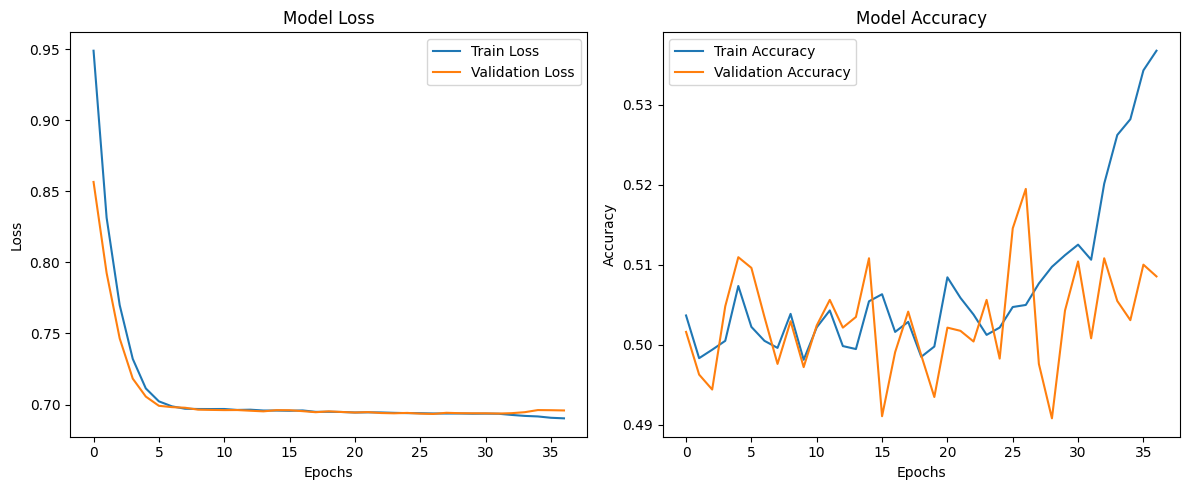

234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
Confusion Matrix:
[[1346 2411]
 [1187 2544]]

Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.36      0.43      3757
           1       0.51      0.68      0.59      3731

    accuracy                           0.52      7488
   macro avg       0.52      0.52      0.51      7488
weighted avg       0.52      0.52      0.51      7488



In [22]:

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()


# Make predictions on validation set
y_pred = (model.predict(X_val) > 0.5).astype(int).flatten()

# Calculate confusion matrix
from sklearn.metrics import confusion_matrix, classification_report

conf_matrix = confusion_matrix(y_val, y_pred)
class_report = classification_report(y_val, y_pred)

print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

In [9]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, LSTM, RepeatVector, Dense, Dropout, BatchNormalization
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# === 1) Derive magnitude labels from Price_Change ===
# Note: train_df, val_df, test_df still contain 'Price_Change'
y_train_mag = train_df['Price_Change'].iloc[window_size:].values
y_val_mag   = val_df['Price_Change'].iloc[window_size:].values
y_test_mag  = test_df['Price_Change'].iloc[window_size:].values

# === 2) Self‑Supervised Pretraining: Sequence Autoencoder ===
ae_in = Input(shape=(window_size, len(feature_cols)))
# Encoder
encoded = LSTM(128, return_sequences=False)(ae_in)
# Decoder
decoded = RepeatVector(window_size)(encoded)
decoded = LSTM(len(feature_cols), return_sequences=True)(decoded)

autoencoder = Model(ae_in, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.fit(
    X_train, X_train,
    validation_data=(X_val, X_val),
    epochs=20,
    batch_size=64,
    verbose=1
)


Epoch 1/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.7972 - val_loss: 0.7263
Epoch 2/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.7074 - val_loss: 0.6994
Epoch 3/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.6833 - val_loss: 0.6808
Epoch 4/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.6672 - val_loss: 0.6665
Epoch 5/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.6542 - val_loss: 0.6550
Epoch 6/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.6431 - val_loss: 0.6442
Epoch 7/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.6336 - val_loss: 0.6353
Epoch 8/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.6266 - val_loss: 0.6312
Epoch 9/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.6194 - val_loss: 0.6252
Epoch 10/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.6147 - val_loss: 0.6202
Epoch 11/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.6091 - val_loss: 0.6158
Epoch 12/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step

In [ ]:
# Extract the encoder
encoder = Model(ae_in, encoded)
# Optionally freeze encoder weights:
# encoder.trainable = False

# === 3) Build Multi‑Task Classifier Using Pretrained Encoder ===
seq_in = Input(shape=(window_size, len(feature_cols)))
x = encoder(seq_in)

# Dense head
x = Dense(256, activation='relu', kernel_regularizer=l2(1e-3))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(1e-3))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# Outputs
dir_out = Dense(1, activation='sigmoid', name='direction')(x)
mag_out = Dense(1, activation='linear',  name='magnitude')(x)

model = Model(seq_in, [dir_out, mag_out])
model.compile(
    optimizer=Adam(1e-3),
    loss={'direction':'binary_crossentropy','magnitude':'mse'},
    loss_weights={'direction':1.0,'magnitude':0.5},
    metrics={'direction':'AUC'}
)

# === 4) Train Classifier ===
model.fit(
    X_train, {'direction': y_train, 'magnitude': y_train_mag},
    validation_data=(X_val, {'direction': y_val, 'magnitude': y_val_mag}),
    epochs=50,
    batch_size=64,
    verbose=1
)

Epoch 1/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - direction_AUC: 0.4959 - direction_loss: 0.8468 - loss: 41366.0820 - magnitude_loss: 82729.7656 - val_direction_AUC: 0.4961 - val_direction_loss: 0.7006 - val_loss: 42822.0391 - val_magnitude_loss: 85641.9375
Epoch 2/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - direction_AUC: 0.4989 - direction_loss: 0.7034 - loss: 41617.4102 - magnitude_loss: 83232.6562 - val_direction_AUC: 0.4976 - val_direction_loss: 0.6956 - val_loss: 42834.5430 - val_magnitude_loss: 85666.9297
Epoch 3/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - direction_AUC: 0.5028 - direction_loss: 0.6958 - loss: 41418.0625 - magnitude_loss: 82833.9219 - val_direction_AUC: 0.4999 - val_direction_loss: 0.6943 - val_loss: 42854.2734 - val_magnitude_loss: 85706.3516
Epoch 4/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - direction_AUC: 0.5012 - direction_loss: 0.6956 - loss: 41574.9648 - magnitude_loss: 83147.7422 - val_direction_AUC: 0.4932 - val_direction_loss: 0.6977 - val_lo

In [11]:

# === 5) Evaluate on Test Set ===
dir_pred_prob, mag_pred = model.predict(X_test)
dir_pred = (dir_pred_prob.flatten() > 0.5).astype(int)

print("Confusion Matrix:")
print(confusion_matrix(y_test, dir_pred))

print("\nClassification Report:")
print(classification_report(y_test, dir_pred))

print(f"\nTest AUC: {roc_auc_score(y_test, dir_pred_prob):.4f}")


235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Confusion Matrix:
[[1788 1981]
 [1821 1899]]

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.47      0.48      3769
           1       0.49      0.51      0.50      3720

    accuracy                           0.49      7489
   macro avg       0.49      0.49      0.49      7489
weighted avg       0.49      0.49      0.49      7489


Test AUC: 0.4880


In [13]:
from tensorflow.keras.layers import (
    Input, Conv1D, SpatialDropout1D, LayerNormalization,
    Bidirectional, LSTM, Dense, Dropout, BatchNormalization,
    Permute, Multiply, Softmax, Lambda, Concatenate
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Attention block
def attention_block(inputs):
    a = Permute((2,1))(inputs)
    a = Dense(inputs.shape[1], activation='tanh')(a)
    a = Softmax(axis=-1)(a)
    a = Permute((2,1))(a)
    weighted = Multiply()([inputs, a])
    return Lambda(lambda x: tf.reduce_sum(x, axis=1))(weighted)

def build_final_model(window_size, n_features):
    seq_in = Input(shape=(window_size, n_features))
    x = SpatialDropout1D(0.2)(seq_in)

    # CNN motif towers
    t1 = Conv1D(64, 3, padding='same', activation='relu')(x)
    t2 = Conv1D(64, 5, padding='same', activation='relu')(x)
    t3 = Conv1D(64, 7, padding='same', activation='relu')(x)
    x = Concatenate()([t1, t2, t3])
    x = LayerNormalization()(x)
    x = Dropout(0.2)(x)

    # Bi‑LSTM + Attention
    x = Bidirectional(LSTM(128, return_sequences=True, dropout=0.2))(x)
    x = LayerNormalization()(x)
    x = Bidirectional(LSTM(64, return_sequences=True, dropout=0.2))(x)
    x = LayerNormalization()(x)
    x = attention_block(x)

    # Dense head
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    out = Dense(1, activation='sigmoid')(x)
    model = Model(seq_in, out)
    model.compile(
        optimizer=Adam(1e-3),
        loss='binary_crossentropy',
        metrics=['AUC','accuracy']
    )
    return model

model = build_final_model(window_size, len(feature_cols))
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50, batch_size=64,
    verbose=1
)

# Evaluate
y_pred_prob = model.predict(X_test).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print(f"\nTest AUC: {roc_auc_score(y_test, y_pred_prob):.4f}")


Epoch 1/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 30s 49ms/step - AUC: 0.4962 - accuracy: 0.4988 - loss: 0.8007 - val_AUC: 0.5044 - val_accuracy: 0.4987 - val_loss: 0.6956
Epoch 2/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 29s 52ms/step - AUC: 0.4982 - accuracy: 0.4994 - loss: 0.7072 - val_AUC: 0.5058 - val_accuracy: 0.5043 - val_loss: 0.6933
Epoch 3/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 29s 53ms/step - AUC: 0.5004 - accuracy: 0.4983 - loss: 0.6964 - val_AUC: 0.5109 - val_accuracy: 0.5071 - val_loss: 0.6932
Epoch 4/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 29s 53ms/step - AUC: 0.4954 - accuracy: 0.5025 - loss: 0.6948 - val_AUC: 0.4993 - val_accuracy: 0.4933 - val_loss: 0.6938
Epoch 5/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 29s 52ms/step - AUC: 0.5065 - accuracy: 0.5027 - loss: 0.6938 - val_AUC: 0.5095 - val_accuracy: 0.5084 - val_loss: 0.6932
Epoch 6/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 31s 56ms/step - AUC: 0.4982 - accuracy: 0.4988 - loss: 0.6942 - val_AUC: 0.5126 - val_accuracy: 0.5031 - val_loss: 0.6930
Epoch 7/50
547/547 ━━━━━━━━━